<a href="https://colab.research.google.com/github/Khalidmamdou7/CMP637-assignments/blob/main/Notebooks/MNIST-autoregressive-models-conditional-MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

## Define utility functions

In [56]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False
use_binary_data = True  # two values only {0, 1} or {0, 255}

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

#### saving models helper functions


In [57]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
import torch
from pathlib import Path
from datetime import datetime

def save_checkpoint(
    model,
    optimizer,
    epoch,
    loss=None,
    base_dir="/content/checkpoints",
    prefix="fvsbn"
):
    """
    Saves model + optimizer with timestamp to avoid overwriting.
    """
    base_dir = Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = base_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved: {path}")
    return path


def load_checkpoint(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    """
    Loads model (and optimizer if provided).
    """
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss



from google.colab import drive

def mount_gdrive(mount_point="/content/drive"):
    drive.mount(mount_point)
    print("Google Drive mounted")

mount_gdrive()


from pathlib import Path
from datetime import datetime
import torch

def save_checkpoint_gdrive(
    model,
    optimizer,
    epoch,
    loss=None,
    drive_dir="/content/drive/MyDrive/fvsbn_checkpoints",
    prefix="fvsbn"
):
    drive_dir = Path(drive_dir)
    drive_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = drive_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved to Google Drive: {path}")
    return path



def load_checkpoint_gdrive(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted


## Load and visualize the dataset

In [58]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: (x > 127).to(torch.uint8) * 255)
        ])
    else:
        transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
else:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: (x > 0.5).float())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

# This will load the dataset into the folder "datasets" the first time it is run
train_dataset = torchvision.datasets.MNIST(root="datasets", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

dataset = train_dataset

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.float32 torch.int64
tensor(0.) tensor(1.)


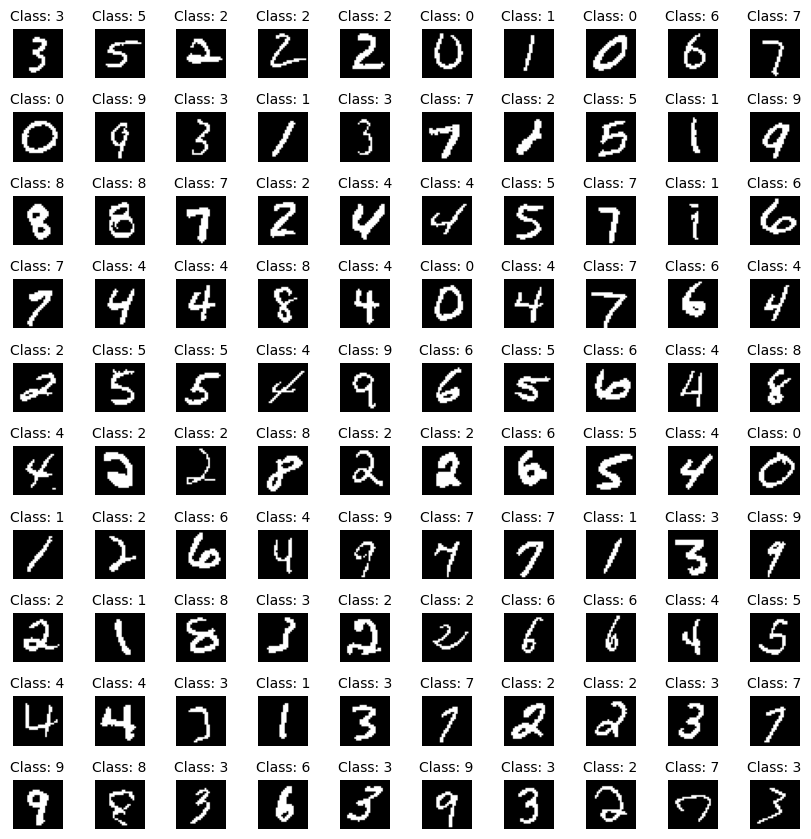

In [59]:
def show_dataset_sample(sample_size: int = 100):
  loader = DataLoader(dataset, batch_size=100, shuffle=True)
  x, y = next(iter(loader))
  print(x.shape, y.shape)
  print(x.dtype, y.dtype)
  print(x.min(), x.max())
#   print(x[0])
#   print(y[0])
  show_images(x, y)

show_dataset_sample()

## Select a device

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cpu


## Define the model

In [61]:
class ConditionalMADE(nn.Module):
    """
    Conditional MADE: models p(x|y)

    The conditioning variable y is concatenated to the input and
    allowed to connect to all hidden units and outputs (no masking on y).
    """

    def __init__(self, n_dims=784, n_classes=10, hidden_sizes=[512], seed=None):
        super(ConditionalMADE, self).__init__()
        self.n_dims = n_dims
        self.n_classes = n_classes
        self.hidden_sizes = hidden_sizes

        # Create embedding for class labels
        self.class_embedding = nn.Embedding(n_classes, n_classes)

        # Adjust input size to include conditioning variable
        input_size = n_dims + n_classes
        layer_sizes = [input_size] + hidden_sizes + [n_dims]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes) - 1)
        ])

        # Create masks (only for x dimensions, not for y)
        masks = self._create_conditional_masks(n_dims, n_classes, hidden_sizes, seed)
        for i, mask in enumerate(masks):
            self.register_buffer(f'mask{i}', mask)

        self.flatten = nn.Flatten(start_dim=1)

    def _create_conditional_masks(self, n_dims, n_classes, hidden_sizes, seed=None):
        """
        Create masks for conditional MADE

        Key difference: conditioning variables (y) can connect to everything
        - Mask only applies to x variables
        - y variables have all 1s (no masking)
        """
        if seed is not None:
            np.random.seed(seed)

        masks = []

        # Connectivity numbers (only for x, not y)
        m_input = np.arange(1, n_dims + 1)

        m_hidden = []
        for hidden_size in hidden_sizes:
            m = np.random.randint(1, n_dims, size=hidden_size)
            m_hidden.append(m)

        m_output = np.arange(1, n_dims + 1)

        # Input -> Hidden[0]
        # Mask shape: (hidden_size, n_dims + n_classes)
        mask_x = (m_hidden[0][:, None] >= m_input[None, :]).astype(np.float32)
        mask_y = np.ones((len(m_hidden[0]), n_classes), dtype=np.float32)
        mask = np.concatenate([mask_x, mask_y], axis=1)
        masks.append(torch.tensor(mask))

        # Hidden[i] -> Hidden[i+1]
        for i in range(len(hidden_sizes) - 1):
            mask = (m_hidden[i+1][:, None] >= m_hidden[i][None, :]).astype(np.float32)
            masks.append(torch.tensor(mask))

        # Hidden[-1] -> Output
        mask = (m_output[:, None] > m_hidden[-1][None, :]).astype(np.float32)
        masks.append(torch.tensor(mask))

        return masks

    def forward(self, x, y):
        """
        Forward pass

        Args:
            x: Input data, shape (batch_size, n_dims) or (batch_size, 1, 28, 28)
            y: Class labels, shape (batch_size,) with values in [0, n_classes-1]

        Returns:
            log_prob: Log probability p(x|y), shape (batch_size,)
        """
        if x.dim() > 2:
            x = self.flatten(x)

        batch_size = x.size(0)

        # Embed class labels and concatenate with x
        y_embedded = self.class_embedding(y)  # (batch_size, n_classes)
        h = torch.cat([x, y_embedded], dim=1)  # (batch_size, n_dims + n_classes)

        # Forward through hidden layers
        for i, layer in enumerate(self.layers[:-1]):
            mask = getattr(self, f'mask{i}')
            masked_weight = layer.weight * mask
            h = F.linear(h, masked_weight, layer.bias)
            h = F.relu(h)

        # Output layer
        mask = getattr(self, f'mask{len(self.layers)-1}')
        masked_weight = self.layers[-1].weight * mask
        logits = F.linear(h, masked_weight, self.layers[-1].bias)

        # Compute log probability
        probs = torch.sigmoid(logits)
        log_prob = (x * torch.log(probs + 1e-8) +
                    (1 - x) * torch.log(1 - probs + 1e-8)).sum(dim=1)

        return log_prob

    def sample(self, n_samples=1, y=None, device='cpu'):
        """
        Generate samples conditioned on class label y

        Args:
            n_samples: Number of samples
            y: Class label(s), can be:
               - Single int: same class for all samples
               - Tensor of shape (n_samples,): different class per sample
               - None: random classes
            device: Device for generation

        Returns:
            samples: shape (n_samples, n_dims)
        """
        self.eval()
        with torch.no_grad():
            # Handle y input
            if y is None:
                y = torch.randint(0, self.n_classes, (n_samples,), device=device)
            elif isinstance(y, int):
                y = torch.full((n_samples,), y, dtype=torch.long, device=device)
            else:
                y = y.to(device)

            # Embed class labels
            y_embedded = self.class_embedding(y)

            samples = torch.zeros(n_samples, self.n_dims, device=device)

            for i in range(self.n_dims):
                # Concatenate current samples with class embedding
                h = torch.cat([samples, y_embedded], dim=1)

                # Through hidden layers
                for j, layer in enumerate(self.layers[:-1]):
                    mask = getattr(self, f'mask{j}')
                    masked_weight = layer.weight * mask
                    h = F.linear(h, masked_weight, layer.bias)
                    h = F.relu(h)

                # Output layer
                mask = getattr(self, f'mask{len(self.layers)-1}')
                masked_weight = self.layers[-1].weight * mask
                logits = F.linear(h, masked_weight, self.layers[-1].bias)

                probs_i = torch.sigmoid(logits[:, i])
                samples[:, i] = torch.bernoulli(probs_i)

        return samples, y

### Un Conditional MADE (NOT USED)

In [62]:
def create_masks(n_dims, hidden_sizes, seed=None):
    """
    Create binary masks for MADE

    Args:
        n_dims: Number of input/output dimensions (e.g., 784 for MNIST)
        hidden_sizes: List of hidden layer sizes, e.g., [512, 512]
        seed: Random seed for reproducibility

    Returns:
        masks: List of binary mask tensors with correct shapes
    """
    if seed is not None:
        np.random.seed(seed)

    masks = []

    # Step 1: Assign connectivity numbers to each unit
    # Input layer: each unit gets its natural number (1, 2, ..., n_dims)
    m_input = np.arange(1, n_dims + 1)  # [1, 2, 3, ..., n_dims]

    # Hidden layers: randomly assign numbers between 1 and n_dims-1
    m_hidden = []
    for hidden_size in hidden_sizes:
        m = np.random.randint(1, n_dims, size=hidden_size)
        m_hidden.append(m)

    # Output layer: same as input (predict each dimension)
    m_output = np.arange(1, n_dims + 1)

    # Step 2: Create masks based on connectivity numbers
    # IMPORTANT: Weight matrix shape is (out_features, in_features)
    # So mask should also be (out_features, in_features)

    # Mask between input and first hidden layer
    # Shape: (hidden_size, n_dims)
    # hidden unit h can connect to input i if m[h] >= m[i]
    mask = (m_hidden[0][:, None] >= m_input[None, :]).astype(np.float32)
    masks.append(torch.tensor(mask))  # NO transpose

    # Masks between hidden layers
    for i in range(len(hidden_sizes) - 1):
        # Shape: (hidden_size[i+1], hidden_size[i])
        mask = (m_hidden[i+1][:, None] >= m_hidden[i][None, :]).astype(np.float32)
        masks.append(torch.tensor(mask))  # NO transpose

    # Mask between last hidden layer and output
    # Shape: (n_dims, hidden_size)
    # output i can only depend on hidden units with m[h] < i
    mask = (m_output[:, None] > m_hidden[-1][None, :]).astype(np.float32)
    masks.append(torch.tensor(mask))  # NO transpose

    return masks

# Example: visualize masks
masks = create_masks(n_dims=4, hidden_sizes=[3], seed=42)
print("Mask shapes:")
for i, mask in enumerate(masks):
    print(f"  Layer {i}: {mask.shape}")
print("\nMask 0 (input to hidden):")
print(masks[0])
print("\nMask 1 (hidden to output):")
print(masks[1])

Mask shapes:
  Layer 0: torch.Size([3, 4])
  Layer 1: torch.Size([4, 3])

Mask 0 (input to hidden):
tensor([[1., 1., 1., 0.],
        [1., 0., 0., 0.],
        [1., 1., 1., 0.]])

Mask 1 (hidden to output):
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 1., 1.]])


In [63]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

class UnConditionalMADE(nn.Module):
    """
    Unconditional Masked Autoencoder for Distribution Estimation

    Architecture:
        Input (n_dims) -> Hidden Layers (with masks) -> Output (n_dims)

    Each output predicts the Bernoulli probability for that dimension
    conditioned on all previous dimensions.
    """

    def __init__(self, n_dims=784, hidden_sizes=[512], seed=None):
        """
        Args:
            n_dims: Number of dimensions (e.g., 784 for MNIST)
            hidden_sizes: List of hidden layer sizes, e.g., [512] or [512, 512]
            seed: Random seed for mask generation
        """
        super(MADE, self).__init__()
        self.n_dims = n_dims
        self.hidden_sizes = hidden_sizes

        # Step 3a: Create network layers
        # Input -> Hidden -> ... -> Hidden -> Output
        layer_sizes = [n_dims] + hidden_sizes + [n_dims]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes) - 1)
        ])

        # Step 3b: Create masks and register as buffers (not parameters)
        masks = create_masks(n_dims, hidden_sizes, seed)
        for i, mask in enumerate(masks):
            # Register as buffer so it's moved to GPU with model but not trained
            self.register_buffer(f'mask{i}', mask)

        # Optional: Flatten layer for image inputs
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        """
        Forward pass through MADE

        Args:
            x: Input tensor of shape (batch_size, n_dims) with values in {0, 1}
               OR (batch_size, 1, 28, 28) for images

        Returns:
            log_prob: Log probability of shape (batch_size,)
        """
        # Step 3c: Flatten if needed
        if x.dim() > 2:
            x = self.flatten(x)

        batch_size = x.size(0)

        # Step 3d: Forward pass through network with masked weights
        h = x
        for i, layer in enumerate(self.layers[:-1]):  # All but last layer
            # Apply mask to weights
            mask = getattr(self, f'mask{i}')
            masked_weight = layer.weight * mask

            # Linear transform with masked weights
            h = F.linear(h, masked_weight, layer.bias)

            # Activation function (ReLU for hidden layers)
            h = F.relu(h)

        # Step 3e: Output layer (no activation, we'll apply sigmoid for probabilities)
        mask = getattr(self, f'mask{len(self.layers)-1}')
        masked_weight = self.layers[-1].weight * mask
        logits = F.linear(h, masked_weight, self.layers[-1].bias)

        # Step 3f: Compute Bernoulli log probability
        # Convert logits to probabilities
        probs = torch.sigmoid(logits)

        # Log probability: log p(x_i | x_<i) for each dimension
        log_prob = (x * torch.log(probs + 1e-8) +
                    (1 - x) * torch.log(1 - probs + 1e-8)).sum(dim=1)

        return log_prob

    def sample(self, n_samples=1, device='cpu'):
        """
        Generate samples from the model

        Args:
            n_samples: Number of samples to generate
            device: Device to generate samples on

        Returns:
            samples: Tensor of shape (n_samples, n_dims) with values in {0, 1}
        """
        self.eval()
        with torch.no_grad():
            samples = torch.zeros(n_samples, self.n_dims, device=device)

            # Step 3g: Sequential sampling (autoregressive)
            # Must sample one dimension at a time due to dependencies
            for i in range(self.n_dims):
                # Forward pass with current partial sample
                h = samples

                # Through hidden layers
                for j, layer in enumerate(self.layers[:-1]):
                    mask = getattr(self, f'mask{j}')
                    masked_weight = layer.weight * mask
                    h = F.linear(h, masked_weight, layer.bias)
                    h = F.relu(h)

                # Output layer
                mask = getattr(self, f'mask{len(self.layers)-1}')
                masked_weight = self.layers[-1].weight * mask
                logits = F.linear(h, masked_weight, self.layers[-1].bias)

                # Get probability for dimension i
                probs_i = torch.sigmoid(logits[:, i])

                # Sample from Bernoulli
                samples[:, i] = torch.bernoulli(probs_i)

        return samples

class FVSBN(nn.Module):
    """
    Fully Visible Sigmoid Belief Network
    """
    def __init__(self, l = 28, w = 28):
        super().__init__()
        self.n_pixels = l * w
        # converting the image from 2d to 1d [28, 28] -> [784]
        self.flatten = nn.Flatten(start_dim=1)  # Flatten all dims except batch

        # Create Parameters for each conditional
        # For pixel i, we need i parameters (including bias)
        # Total parameters: 1 + 2 + 3 + ... + n = n(n+1)/2
        weights_scaling_factor = 0.01
        self.params = nn.ParameterList([
            nn.Parameter(torch.randn(i + 1) * weights_scaling_factor) # [bias, alpha_0, alpha_1, .., alpha_i-1]
            for i in range(self.n_pixels)
        ])

    def forward(self, x):
        """
        Computes log probability of x
        Args:
            x: [Batch, Channels, Height, Width] [100, 1, 28, 28] with values in {0, 1}
        returns: logits for Bernoulli distribution
        """
        # Handle both flattened and unflattened input
        if x.dim() > 2:
            x = self.flatten(x)  # (batch_size, 1, 28, 28) -> (batch_size, 784)


        batch_size = x.size(0)
        log_prob = torch.zeros(batch_size, device=x.device)


        for i in range(self.n_pixels):
            params = self.params[i].to(x.device)

            if i == 0:
                # First pixel: only bias
                # expand repeats for the whole batches
                logits = params[0].expand(batch_size)
            else:
                # Other pixels
                # Compute: bias + sum(alpha_j * x_j) for j < i
                bias = params[0]
                weights = params[1:]    # shape: (i,)
                x_prev = x[:, :i]       # shape: (batch_size, i)
                logits = bias + torch.sum(weights * x_prev, dim=1)

            # Compute Bernoulli probability
            probs = torch.sigmoid(logits)

            # P(X = x) = p^x * (1-p)^(1-x)
            # Log probability: log p(x_i | x_<i)
            # log P(X = x) = x * log(p) + (1-x) * log(1-p)
            # 1e-8 is for numerical stability to prevent log(0) = -inf
            log_prob += x[:, i] * torch.log(probs + 1e-8) + \
                (1 - x[:, i]) * torch.log(1 - probs + 1e-8)

        return log_prob

    def sample(self, n_samples=1, device='cpu'):
        """Returns samples in {0, 1}"""
        samples = torch.zeros(n_samples, self.n_pixels, device=device)
        for i in range(self.n_pixels):
            params = self.params[i].to(device)

            if i == 0:
                # First pixel: only bias
                # expand repeats for the whole batches
                logits = params[0].expand(n_samples)
            else:
                # Other pixels
                bias = params[0]
                weights = params[1:]
                x_prev = samples[:, :i]
                logits = bias + torch.sum(weights * x_prev, dim=1)

            probs = torch.sigmoid(logits)
            samples[:, i] = torch.bernoulli(probs)

        return samples




## Define Hyperparameters

In [64]:
# TODO: Define the hyperparameters here.
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

n_dims = 784  # 28x28 MNIST images
hidden_sizes = [512]  # Can try [512, 512] for deeper network
seed = 42

## Instantiate models and optimizers

In [65]:
# TODO: Instantiate the models and optimizers here.
print(device)
# model = FVSBN(l = 28, w = 28).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = ConditionalMADE(n_dims=n_dims, n_classes=10, hidden_sizes=hidden_sizes).to(device)

# model = MADE(
#         n_dims=n_dims,
#         hidden_sizes=hidden_sizes,
#         seed=seed
#     ).to(device)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu
Model parameters: 809,332


## Train the model

In [66]:

# checkpoint_path = "/content/checkpoints/fvsbn_epoch4_20251224_143015.pt"

# start_epoch, last_loss = load_checkpoint(
#     model=model,
#     optimizer=optimizer,
#     path=checkpoint_path,
#     device=device
# )

# for epoch in range(start_epoch + 1, num_epochs):
#     ...

train_losses = []


model.train()

for epoch in range(1, num_epochs + 1):
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        # Forward pass: compute log probability
        log_prob = model(data, labels)

        # Loss: negative log likelihood (we want to maximize log_prob)
        loss = -log_prob.mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'====> Epoch {epoch} Average loss: {avg_loss:.4f}')


    # save after each epoch
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item(),
        prefix='conditional-made'
    )


Epoch 1, Batch 0/600, Loss: 543.5731
Epoch 1, Batch 100/600, Loss: 190.4476
Epoch 1, Batch 200/600, Loss: 161.7965
Epoch 1, Batch 300/600, Loss: 142.4773
Epoch 1, Batch 400/600, Loss: 128.9173
Epoch 1, Batch 500/600, Loss: 124.6544
====> Epoch 1 Average loss: 169.2534
Checkpoint saved: /content/checkpoints/conditional-made_epoch1_20251225_120747.pt
Epoch 2, Batch 0/600, Loss: 114.2131
Epoch 2, Batch 100/600, Loss: 116.3769
Epoch 2, Batch 200/600, Loss: 108.8482
Epoch 2, Batch 300/600, Loss: 104.8599
Epoch 2, Batch 400/600, Loss: 104.9005
Epoch 2, Batch 500/600, Loss: 100.7356
====> Epoch 2 Average loss: 108.1143
Checkpoint saved: /content/checkpoints/conditional-made_epoch2_20251225_120813.pt
Epoch 3, Batch 0/600, Loss: 92.9386
Epoch 3, Batch 100/600, Loss: 102.0987
Epoch 3, Batch 200/600, Loss: 94.2942
Epoch 3, Batch 300/600, Loss: 94.6574
Epoch 3, Batch 400/600, Loss: 94.7133
Epoch 3, Batch 500/600, Loss: 93.2530
====> Epoch 3 Average loss: 95.7639
Checkpoint saved: /content/checkpoi

## [Optional] Save and/or load the model

In [67]:
save_checkpoint_gdrive(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item(),
        drive_dir='/content/drive/MyDrive/ai-models/gen-ai/made_checkpoints',
        prefix="conditional-MADE"
    )

Checkpoint saved to Google Drive: /content/drive/MyDrive/ai-models/gen-ai/made_checkpoints/conditional-MADE_epoch10_20251225_121121.pt


PosixPath('/content/drive/MyDrive/ai-models/gen-ai/made_checkpoints/conditional-MADE_epoch10_20251225_121121.pt')

## Write the generation function

In [70]:
# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32
def generate(y: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        batch_size = y.shape[0]
        samples, _ = model.sample(n_samples=batch_size, y=y, device=device)
        samples = samples.view(batch_size, 1, 28, 28)
        return samples

## Generate some images and display them

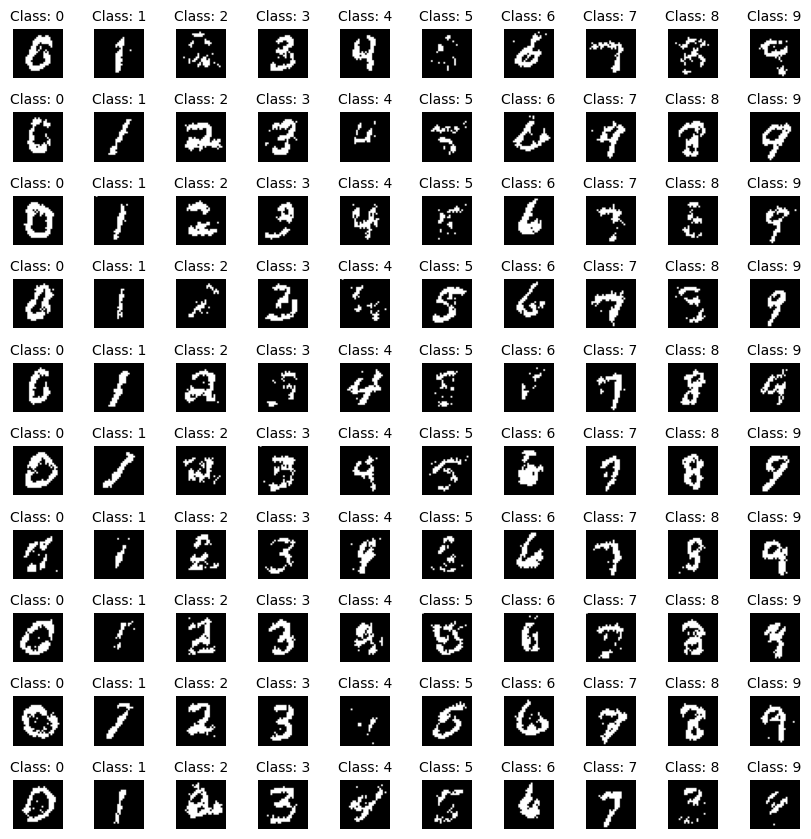

In [71]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).

### Loss Function graph

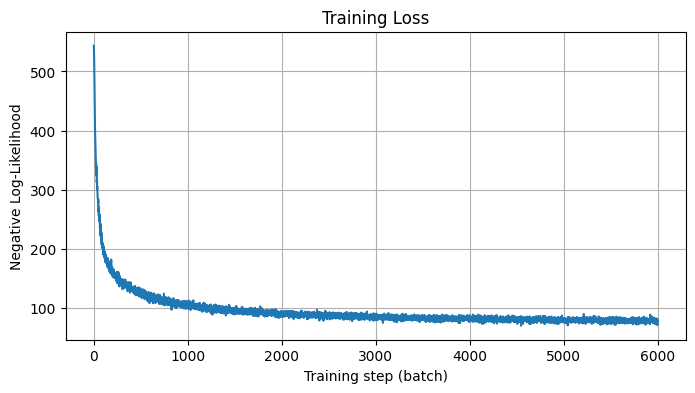

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Training step (batch)")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Loss")
plt.grid(True)
plt.show()

